In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('dataset.csv', index_col='Month', parse_dates=True,date_parser=lambda x: pd.to_datetime(x, format='%y-%b'))

df_prod = df[['Production']]
df_prod.interpolate(method='time', inplace=True)


<Axes: xlabel='Month'>

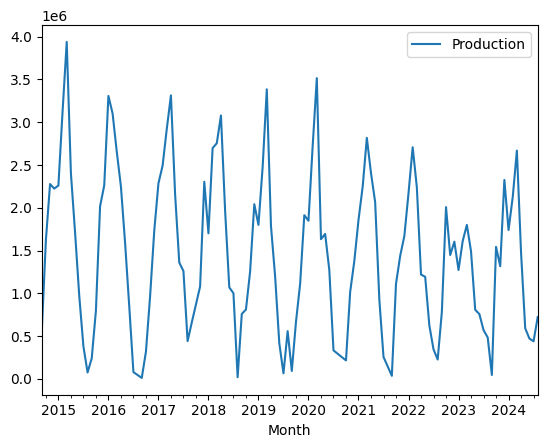

In [3]:
df_prod.plot()

In [4]:
# find the months with missing values
missing_months = df[df['Production'].isnull()].index
print(missing_months)

# Get the value of 'Production' for a specific date
specific_date = ['2020-08-01','2020-09-01', '2021-08-01']
value = df_prod.loc[specific_date, 'Production']
value



DatetimeIndex([], dtype='datetime64[ns]', name='Month', freq=None)


Month
2020-08-01    292851.0
2020-09-01    253199.0
2021-08-01    144667.0
Name: Production, dtype: float64

In [5]:
df_prod.tail()

,Production
Month,
2024-04-01,1476667.0
2024-05-01,590428.0
2024-06-01,470766.0
2024-07-01,438518.0
2024-08-01,722192.0


Do a forecasting to fill the missing data on the 3 months

In [6]:
from statsmodels.tsa.stattools import adfuller

def ADF_test(data):
    p = adfuller(data)[1]
    print (f'P-value: {p} < 0.05')
    if p < 0.05:
        print('Series is stationary')
    else:
        print('Series is not stationary')

In [7]:
ADF_test(df_prod)

P-value: 0.2760270877045634 < 0.05
Series is not stationary


P-value: 2.9231354145461644e-15 < 0.05
Series is stationary


(<Axes: xlabel='Month'>, None)

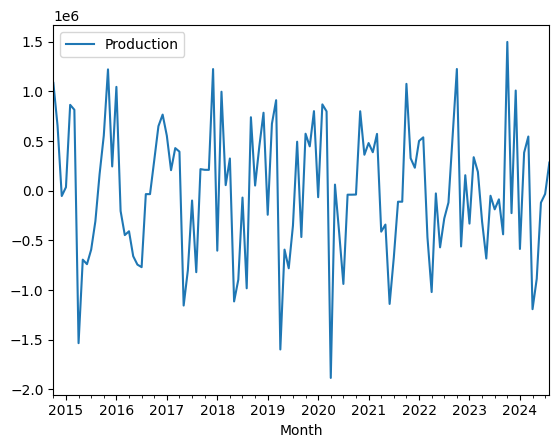

In [8]:
diff_prod = df_prod.diff().dropna()

diff_prod.plot(), ADF_test(diff_prod)

### Train test Split


In [9]:
total = len(df_prod)

train_size = int(total - 24)
test_size = 24 

train = df_prod.iloc[:96]
test = df_prod.iloc[96:]

total, train_size, test_size

(120, 96, 24)

,Production
Month,
2014-09-01,537770.0
2014-10-01,1623075.0
2014-11-01,2277043.0
2014-12-01,2223994.0
2015-01-01,2259613.0
...,...
2022-04-01,1219338.0
2022-05-01,1192380.0
2022-06-01,622708.0


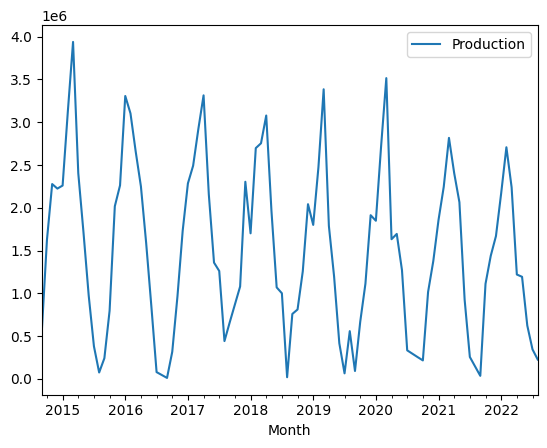

In [10]:
train_prod = train[['Production']]
train_prod.plot()
train_prod

(            Production
 Month                 
 2022-09-01    782119.0
 2022-10-01   2007522.0
 2022-11-01   1446898.0
 2022-12-01   1603146.0
 2023-01-01   1272210.0
 2023-02-01   1610065.0
 2023-03-01   1800101.0
 2023-04-01   1489215.0
 2023-05-01    806884.0
 2023-06-01    756657.5
 2023-07-01    569482.0
 2023-08-01    482943.5
 2023-09-01     44419.0
 2023-10-01   1542323.0
 2023-11-01   1316907.0
 2023-12-01   2325542.0
 2024-01-01   1739690.0
 2024-02-01   2122968.0
 2024-03-01   2668661.0
 2024-04-01   1476667.0
 2024-05-01    590428.0
 2024-06-01    470766.0
 2024-07-01    438518.0
 2024-08-01    722192.0,
 <Axes: xlabel='Month'>)

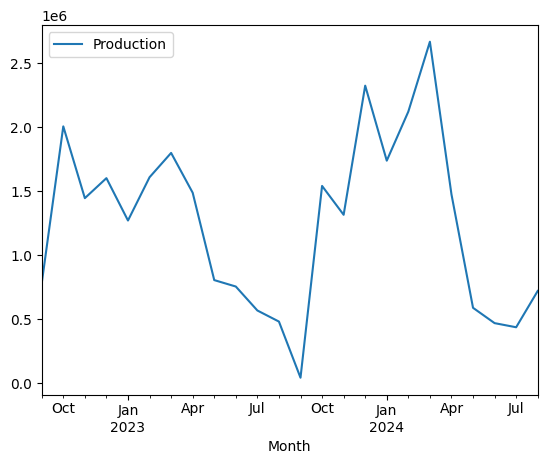

In [11]:
test_prod = test[['Production']]
test_prod, test_prod.plot()

In [12]:
ADF_test(train_prod)

P-value: 3.21005931940272e-13 < 0.05
Series is stationary


## Modelling

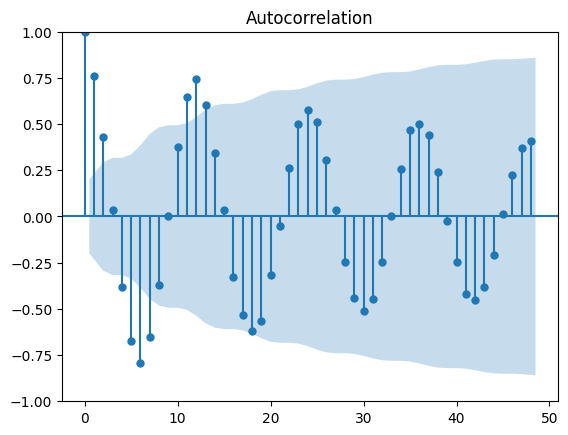

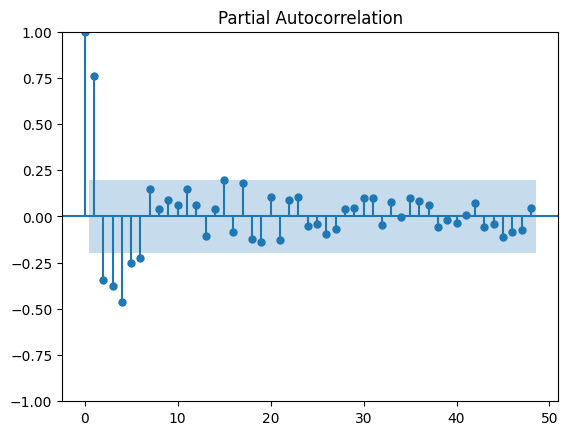

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(train_prod, lags=48);
plot_pacf(train_prod, lags=48);

In [14]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import warnings

warnings.filterwarnings("ignore")

def determine_best_arima_order(data, max_p=5, max_d=2, max_q=5):
    best_aic = float("inf")
    best_order = None
    best_model = None
    
    for p in range(max_p + 1):
        for d in range(max_d + 1):
            for q in range(max_q + 1):
                try:
                    model = ARIMA(data, order=(p, d, q)).fit()
                    if model.aic < best_aic:
                        best_aic = model.aic
                        best_order = (p, d, q)
                        best_model = model
                except:
                    continue
    
    print(f"Best ARIMA order: {best_order} with AIC: {best_aic}")
    return best_order, best_model

# Example usage:
best_order, best_model = determine_best_arima_order(train_prod['Production'])

Best ARIMA order: (3, 2, 5) with AIC: 2732.4687231841717


Actual: 782119.0, Predicted: 748612.8058658831
Actual: 2007522.0, Predicted: 1377400.7016133256
Actual: 1446898.0, Predicted: 1949336.7252131365
Actual: 1603146.0, Predicted: 2337408.444376526
Actual: 1272210.0, Predicted: 2474861.69927363
Actual: 1610065.0, Predicted: 2362855.0692547327
Actual: 1800101.0, Predicted: 2061106.5248608496
Actual: 1489215.0, Predicted: 1666007.848982208
Actual: 806884.0, Predicted: 1283033.635236444
Actual: 756657.5, Predicted: 1000701.7154751306
Actual: 569482.0, Predicted: 872006.3965327741
Actual: 482943.5, Predicted: 906695.2914731051
Actual: 44419.0, Predicted: 1074757.6101847421
Actual: 1542323.0, Predicted: 1318803.7935103548
Actual: 1316907.0, Predicted: 1571233.8818634597
Actual: 2325542.0, Predicted: 1771513.467963206
Actual: 1739690.0, Predicted: 1879476.6814748093
Actual: 2122968.0, Predicted: 1882056.367228825
Actual: 2668661.0, Predicted: 1792736.2581480863
Actual: 1476667.0, Predicted: 1644827.2295888602
Actual: 590428.0, Predicted: 1480975.

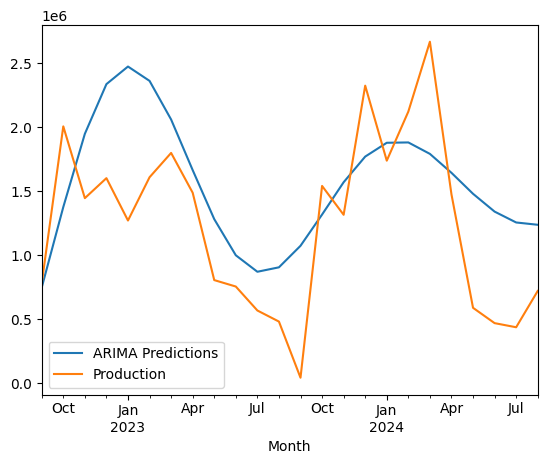

In [23]:
from statsmodels.tsa.arima.model import ARIMA


model = ARIMA(train_prod, order=(2,0,1)).fit()

start = len(train_prod)
end = start + len(test_prod) - 1

pred = model.predict(start=start, end=end, typ='levels', dynamic=False).rename('ARIMA Predictions')
pred.plot(legend=True)
test_prod['Production'].plot(legend=True)

def Compare(pred, test):
    for i in range(len(pred)):
        print(f'Actual: {test[i]}, Predicted: {pred[i]}')


Compare(pred, test_prod['Production'])

## Forecasting

(<Axes: >,
 2024-06-01     500485
 2024-07-01     651269
 2024-08-01     967147
 2024-09-01    1346722
 2024-10-01    1690798
 2024-11-01    1925140
 2024-12-01    2013576
 2025-01-01    1960027
 2025-02-01    1800855
 2025-03-01    1590927
 2025-04-01    1387714
 2025-05-01    1237458
 2025-06-01    1166279
 2025-07-01    1177469
 2025-08-01    1254569
 2025-09-01    1368521
 2025-10-01    1486565
 2025-11-01    1580495
 2025-12-01    1632472
 2026-01-01    1637434
 2026-02-01    1602132
 2026-03-01    1541565
 2026-04-01    1474102
 2026-05-01    1416629
 Freq: MS, Name: Forecast, dtype: object)

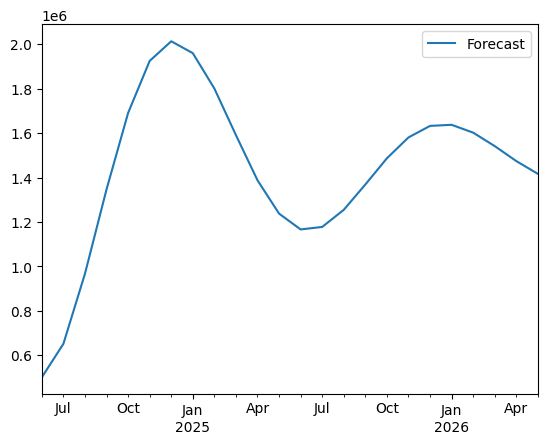

In [24]:
skip_last = df_prod.iloc[:117]

final_model = ARIMA(skip_last, order=(2,0,1)).fit()
forecast = final_model.forecast(steps=24).rename('Forecast')
forecast.plot(legend=True), forecast.apply(lambda x: f"{x:.0f}")


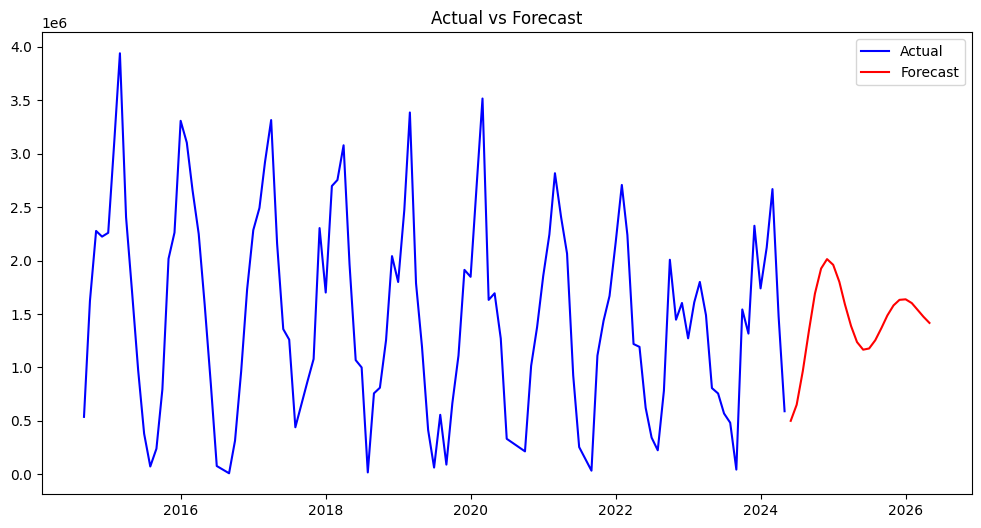

In [25]:
def Compare_plot(actual, forecast):
    plt.figure(figsize=(12, 6))
    plt.plot(actual, label='Actual', color='blue')
    plt.plot(forecast, label='Forecast', color='red')
    plt.title('Actual vs Forecast')
    plt.legend()
    plt.show()

# Call the function to plot
Compare_plot(skip_last, forecast)
